In [1]:
import os
os.chdir("/home/robbe/ionbot/")
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np
import seaborn as sns
import OxiAnalysis as OA
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from pyteomics import mass as pymass
import re
import importlib
importlib.reload(OA)

<module 'OxiAnalysis' from '/home/robbe/ionbot/OxiAnalysis.py'>

In [2]:
pvallist = []

In [3]:
def boxplots(Controldf, Treatmentdf, specific=True):
    db = pymass.Unimod()

    pvallist = []
    for index, row in Controldf.iterrows():
        for index2, row2 in Treatmentdf.iterrows():
            if index == index2:
                if specific:
                    mod = row["Modifications"]
                    modname = re.search(pattern=r"\[\d+\](.*)", string=mod).group(1)
                else:
                    mod = row["UnimodAccession"]
                    modname = mod
                dataControl = Controldf.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatmentdf.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                if dataTreatment.size != 0 and dataControl.size != 0:
                    pval = stats.mannwhitneyu(dataControl, dataTreatment).pvalue
                    pvallist.append(pval)
                    if pval < 0.05:
                        plt.figure(figsize=(6,6))
                        df = pd.DataFrame({"Control subjects": pd.Series(dataControl.values), "AD patients": pd.Series(dataTreatment.values)})
                        
                        ax = sns.boxplot(data=df)
                        pairs = list(combinations(["Control subjects", "AD patients"], r=2))
                        annotator = Annotator(ax, pairs = pairs, data=df)
                        annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
                        annotator.apply_and_annotate()
                        sns.stripplot(data=df, alpha = 0.7, color="black")
                        
                        plt.title("{}-modified peptide intensities".format(modname))
                        plt.ylabel("Summed PTM abundances")
                        plt.savefig("/home/robbe/ionbot/Images/AD_boxplot_{}".format(modname), dpi=400)
                        plt.show()
                        
    corrected_pvals = multipletests(pvallist, method= "fdr_bh")[1].tolist()
    for i in zip(pvallist, corrected_pvals):
        if i[0] < 0.05:
            print("{} => {}".format(i[0], i[1]))
                

# Alzheimer oxPTM analysis

In [6]:
quantnorm = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
quantnorm.drop(list(quantnorm.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quantnorm = quantnorm[~quantnorm["Protein Groups"].str.contains("sp|", na=False, regex=False)]

quantnorm.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,194429.501953,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,1.407283e+06,1.882486e+06,0.0,0.0,0.0,0.0,0.0,2.078671e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,4.562765e+06,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [7]:
cols = [col for col in quantnorm.columns if "Intensity" in col]

In [8]:
quantnorm = OA.quantile_transform(quantnorm, cols)
quantnorm[cols] = quantnorm[cols].transform(lambda x: x/x.sum())

In [9]:
summedintensitiesnorm = OA.summedintensities(quantnorm)

/home/robbe/ionbot/OxiAnalysis.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantexox.drop(list(quantexox.filter(regex = 'Detection Type')), axis = 1, inplace = True)


In [10]:
Controldfnorm = summedintensitiesnorm.filter(regex="Modifications|ctrl2")
ADdfnorm = summedintensitiesnorm.filter(regex="Modifications|AD2")

In [11]:
Controldfnorm

,Modifications,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction03,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction04,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction05,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction06,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction07,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction08,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction09,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction15,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24
0,[1384]Homocysteic_acid[M],0.000545,0.000234,0.000322,0.000344,0.000100,0.000215,0.000309,0.000483,0.000253,...,0.000082,0.000120,0.000181,0.000136,0.000284,0.000202,0.000164,0.000348,0.000357,0.000177
1,[1914]Met->AspSA[M],0.001787,0.000873,0.000659,0.000623,0.000924,0.001025,0.001141,0.001175,0.001176,...,0.000671,0.000980,0.001042,0.000800,0.001101,0.000491,0.000860,0.001252,0.001136,0.000915
2,[1915]Decarboxylation[D],0.000000,0.000145,0.000522,0.000327,0.000649,0.000371,0.000851,0.000622,0.000254,...,0.000365,0.000228,0.000110,0.000216,0.000398,0.000749,0.001651,0.001849,0.001183,0.000364
3,[1915]Decarboxylation[E],0.000523,0.000387,0.001039,0.000620,0.000774,0.000486,0.000732,0.000657,0.000301,...,0.000811,0.000603,0.000547,0.000557,0.000711,0.000556,0.000979,0.001630,0.001624,0.000644
4,[1916]Aspartylurea[H],0.000353,0.000773,0.000436,0.000783,0.000850,0.000340,0.000393,0.000514,0.000614,...,0.000445,0.000612,0.000287,0.000567,0.000677,0.001055,0.001278,0.001213,0.000865,0.000508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,[743]4-ONE+Delta:H(-2)O(-1)[K],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86,[860]G-H1[R],0.000237,0.000370,0.000425,0.000470,0.000343,0.000360,0.000347,0.000497,0.000383,...,0.000838,0.000967,0.000524,0.000455,0.000440,0.000299,0.000524,0.000549,0.000751,0.000791
87,[936]Chlorination[Y],0.000000,0.000000,0.000000,0.000196,0.000114,0.000102,0.000000,0.000000,0.000000,...,0.000000,0.000186,0.000076,0.000000,0.000116,0.000086,0.000115,0.000244,0.000098,0.000115
88,[937]dichlorination[Y],0.000000,0.000000,0.000087,0.000107,0.000114,0.000090,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000131,0.000141,0.000000,0.000000


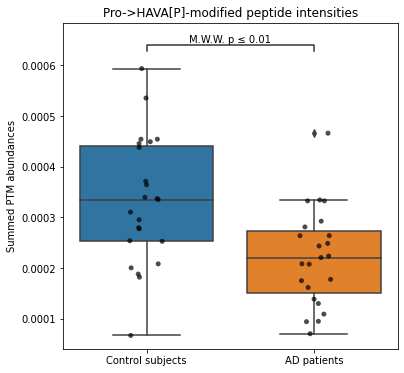

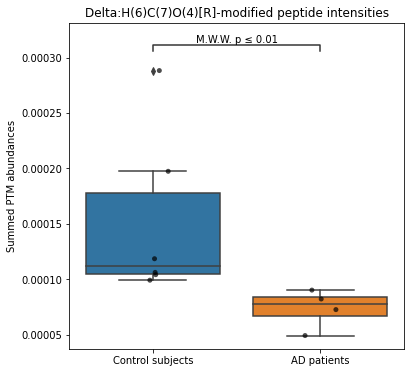

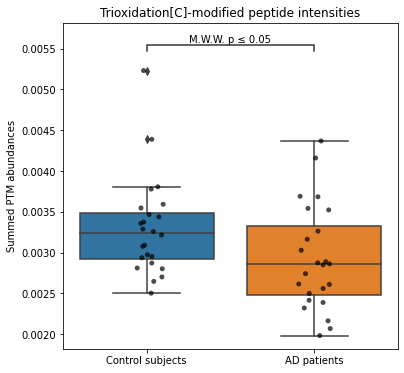

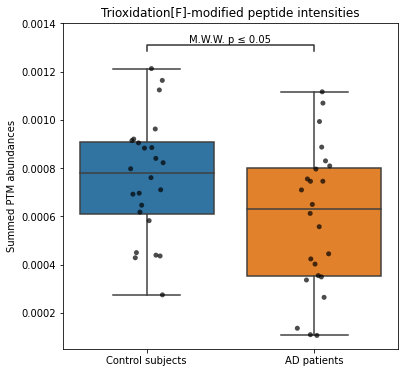

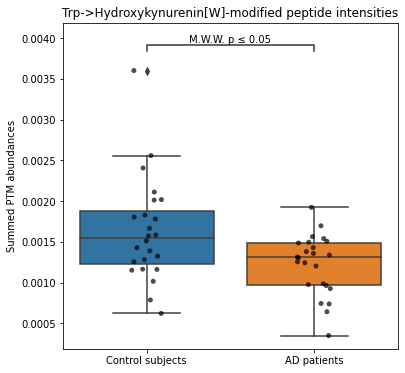

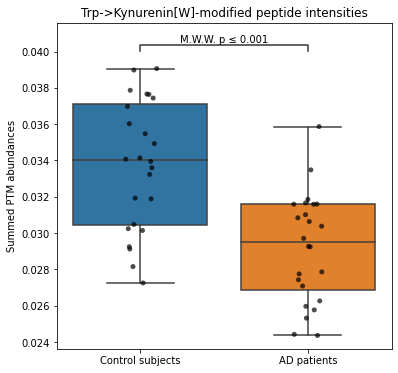

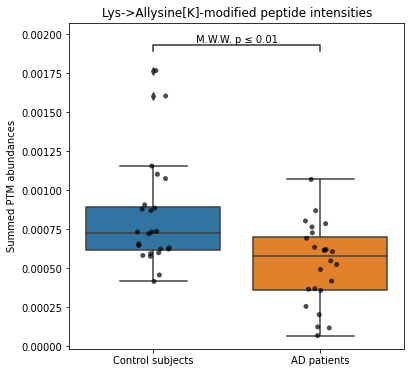

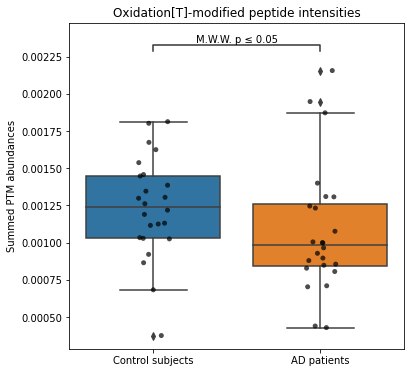

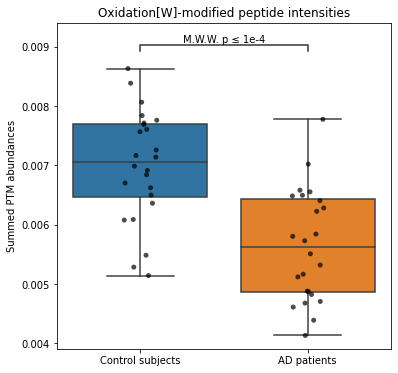

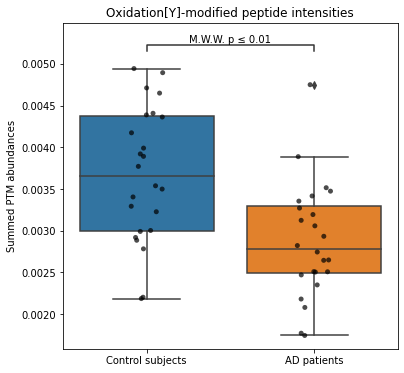

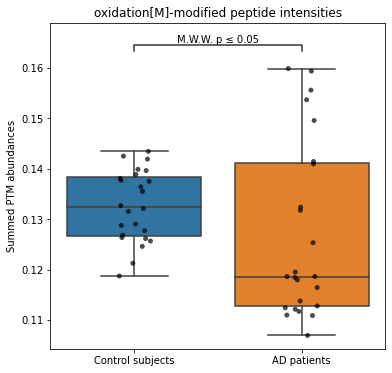

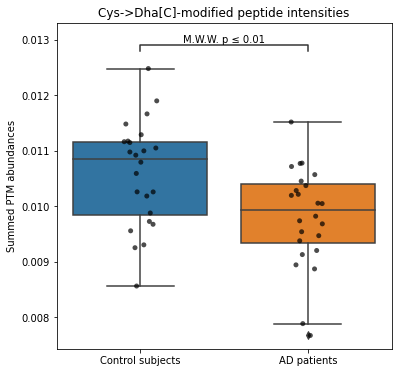

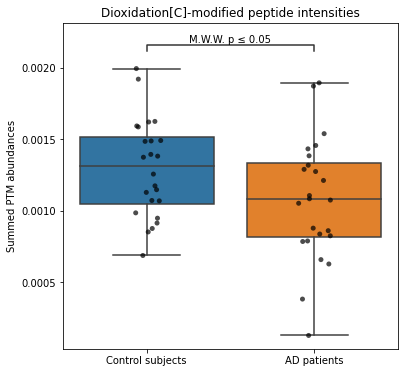

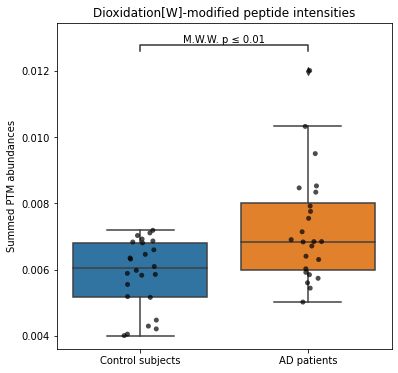

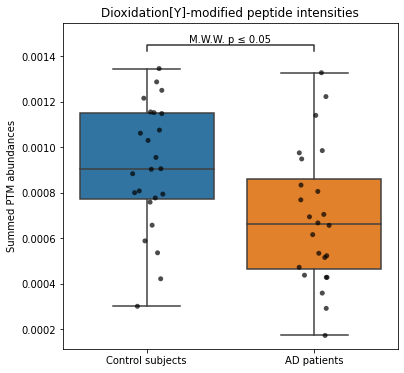

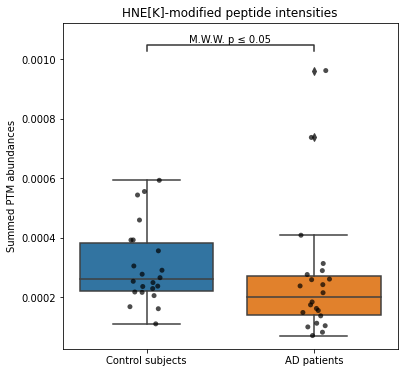

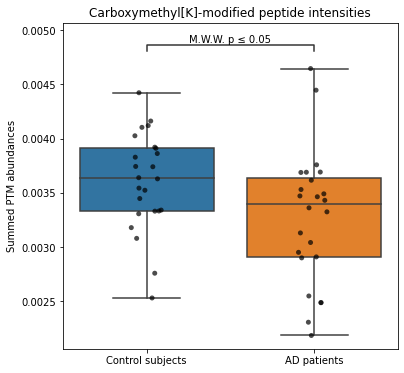

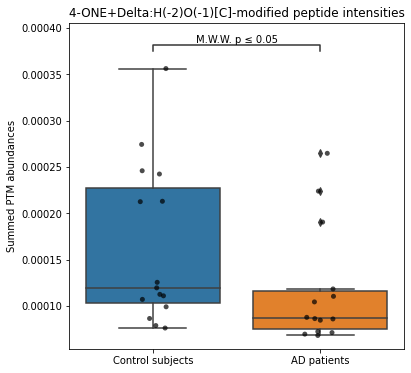

0.00210019399467505 => 0.04567921938418234
0.009523809523809525 => 0.10357142857142858
0.028092445265394367 => 0.22218570346266453
0.04438716620569989 => 0.24135521624349318
0.01822817785893125 => 0.15858514737270188
0.00013080100099724853 => 0.005689843543380311
0.002698383221760215 => 0.04695186805862774
0.04438716620569989 => 0.24135521624349318
4.258258549382776e-05 => 0.0037046849379630147
0.0010060313623902943 => 0.029174909509318534
0.04225136632956884 => 0.24135521624349318
0.0059101770309275825 => 0.07821459292863975
0.048932790787893914 => 0.24166648875554858
0.006293128166672163 => 0.07821459292863975
0.011539988490258973 => 0.11155322207250341
0.04999996319080315 => 0.24166648875554858
0.03118111444371902 => 0.2260630797169629
0.04241488053789996 => 0.24135521624349318


In [12]:
boxplots(Controldfnorm, ADdfnorm)

# Non-Specific

In [13]:
summedintensitiesnorm["UnimodAccession"] = summedintensitiesnorm["Modifications"].apply(OA.get_unimod_acc)

In [14]:
nssi = summedintensitiesnorm.groupby("UnimodAccession").sum().reset_index()

In [15]:
Controldf = nssi.filter(regex="UnimodAccession|ctrl2")
ADdf = nssi.filter(regex="UnimodAccession|AD2")

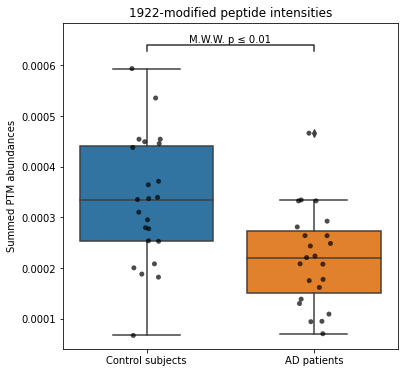

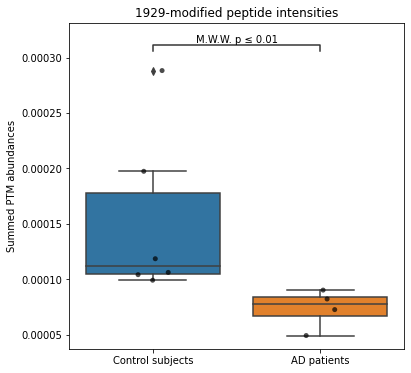

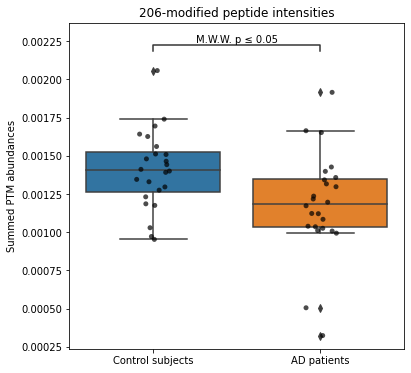

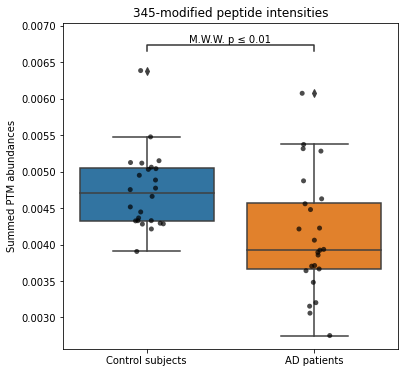

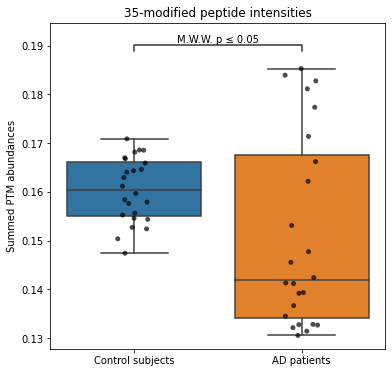

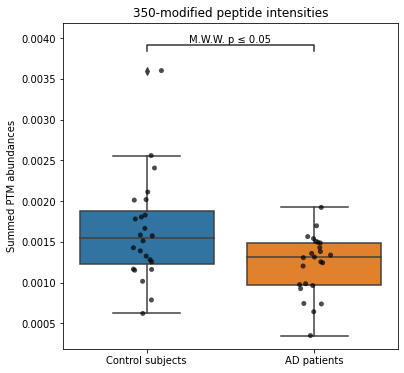

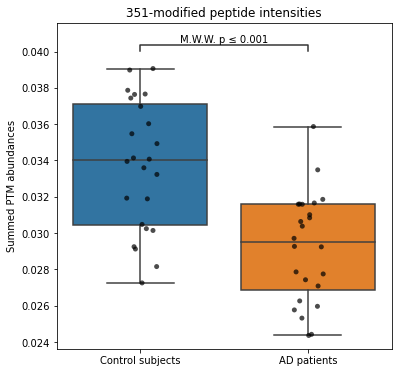

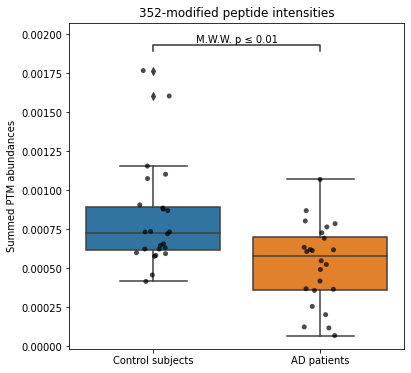

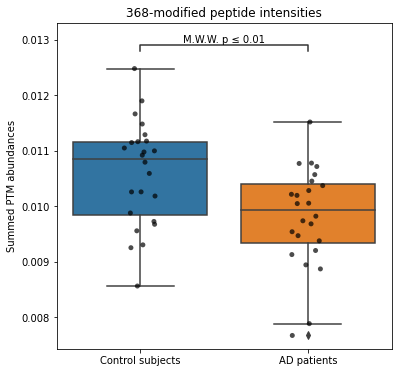

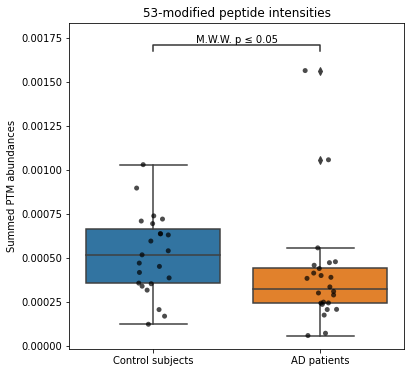

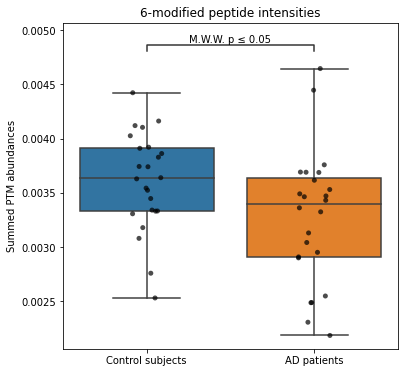

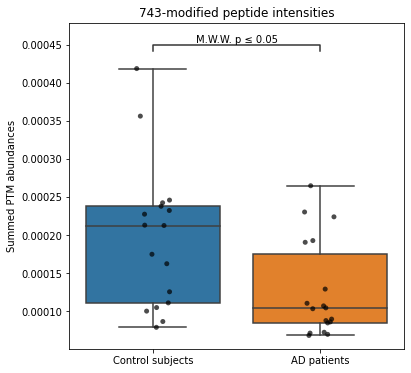

0.00210019399467505 => 0.029007619633922312
0.009523809523809525 => 0.06825396825396826
0.01223517995219624 => 0.0749148549213773
0.0025212523590803287 => 0.029007619633922312
0.02664957303127472 => 0.10417560366771027
0.01822817785893125 => 0.07838116479340437
0.00013080100099724853 => 0.005624443042881687
0.002698383221760215 => 0.029007619633922312
0.0059101770309275825 => 0.05082752246597721
0.017650112808849434 => 0.07838116479340437
0.03118111444371902 => 0.11173232675665982
0.013937647427232986 => 0.0749148549213773


In [16]:
boxplots(Controldf=Controldf, Treatmentdf=ADdf, specific=False)

# MSFragger validation of Trioxidation downregulation?

In [17]:
quant = pd.read_csv("/home/robbe/ionbot/Fragpipe_results/PXD016278/QuantifiedPeptides.tsv", sep="\t")
quant.drop(list(quant.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quant = quant[~quant["Protein Groups"].str.contains("sp|", na=False, regex=False)]

quant.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAK|nan|nan,AAAAAAAAAAAAAAAGAGAGAK,P55011,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
1,AAAAAAALQAK|nan|Mod1: 2-amino-3-oxo-butanoic_a...,AAAAAAALQAK,P36578,NaN,NaN,0.0,0.0,4.783178e+06,2.405819e+06,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
2,AAAAAAALQAK|nan|nan,AAAAAAALQAK,P36578,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
3,AAAATGTIFTFR|nan|Mod1: Formylation (PeakApex: ...,AAAATGTIFTFR,P05154,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,6.230569e+05,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN
4,AAAATGTIFTFR|nan|nan,AAAATGTIFTFR,P05154,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,1.943068e+06,1.020630e+08,0.0,0.0,0.0,0.0,0.0,7989761.75,37485756.5,NaN


In [18]:
cols = [col for col in quant.columns if "Intensity" in col]

In [19]:
quantnorm = OA.quantile_transform(quant, cols)
quantnorm[cols] = quantnorm[cols].transform(lambda x: x/x.sum())

In [20]:
quantnorm

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAK|nan|nan,AAAAAAAAAAAAAAAGAGAGAK,P55011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAALQAK|nan|Mod1: 2-amino-3-oxo-butanoic_a...,AAAAAAALQAK,P36578,NaN,NaN,NaN,NaN,0.000113,0.000095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAALQAK|nan|nan,AAAAAAALQAK,P36578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAATGTIFTFR|nan|Mod1: Formylation (PeakApex: ...,AAAATGTIFTFR,P05154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAATGTIFTFR|nan|nan,AAAATGTIFTFR,P05154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000084,0.000125,NaN,NaN,NaN,NaN,NaN,0.000126,0.000125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99732,YYWGGQYTWDMAK|nan|Mod1: formaldehyde adduct (P...,YYWGGQYTWDMAK,P02675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99733,YYWGGQYTWDMAK|nan|nan,YYWGGQYTWDMAK,P02675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000105,0.000097,NaN,NaN,NaN,NaN,NaN,0.000106,0.000126,NaN
99734,YYYAVYDMVVR|nan|nan,YYYAVYDMVVR,P07942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99735,YYYDGKDYIEFNK|nan|Mod1: Iodoacetamide derivati...,YYYDGKDYIEFNK,P25311,NaN,NaN,NaN,NaN,NaN,NaN,0.000071,...,NaN,0.000078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
cysteic = quantnorm[quantnorm["Sequence"].str.contains(r"cysteine oxidation to cysteic acid(,| )")]

/tmp/ipykernel_3791406/3385792818.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cysteic = quantnorm[quantnorm["Sequence"].str.contains(r"cysteine oxidation to cysteic acid(,| )")]


In [22]:
cysteic

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
137,AADDTWEPFASGK|nan|Mod1: cysteine oxidation to ...,AADDTWEPFASGK,P02766,NaN,NaN,0.00019,0.000155,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000118,0.000157,0.000153,NaN,NaN
489,AAFTECCQAADK|7C(57.0214)|Mod1: cysteine oxidat...,AAFTECCQAADK,P02768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000082,NaN,0.000078,NaN,NaN,NaN,NaN,NaN
1312,ADDKETCFAEEGK|nan|Mod1: cysteine oxidation to ...,ADDKETCFAEEGK,P02768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000116,0.000105,NaN,NaN,NaN,NaN,NaN
1352,ADDKETCFAEEGKK|7C(57.0214)|Mod1: cysteine oxid...,ADDKETCFAEEGKK,P02768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000095,0.000106,NaN,NaN,NaN,NaN,NaN
1388,ADDKETCFAEEGKK|nan|Mod1: cysteine oxidation to...,ADDKETCFAEEGKK,P02768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000100,0.000105,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98699,YPSLSIHGIEGAFDEPGTK|nan|Mod1: Second isotopic ...,YPSLSIHGIEGAFDEPGTK,Q96KN2,NaN,NaN,NaN,NaN,0.000101,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99163,YTIAALLSPYSYSTTAVVTNPK|nan|Mod1: cysteine oxid...,YTIAALLSPYSYSTTAVVTNPK,P02766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99331,YVGGQEHFAHLLILR|nan|Mod1: cysteine oxidation t...,YVGGQEHFAHLLILR,P02763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99388,YVGGQEHFAHLLILR|nan|Mod1: Second isotopic peak...,YVGGQEHFAHLLILR,P02763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cysteic.drop(["Sequence", "Base Sequence", "Protein Groups", "Gene Names", "Organism", "Unnamed: 101"], inplace=True, axis=1)

/tmp/ipykernel_3791406/3641690104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cysteic.drop(["Sequence", "Base Sequence", "Protein Groups", "Gene Names", "Organism", "Unnamed: 101"], inplace=True, axis=1)


In [24]:
sums = cysteic.sum()

In [25]:
ADsums = sums.filter(regex="AD2")
Controlsums = sums.filter(regex="ctrl")

In [26]:
pval = stats.mannwhitneyu(Controlsums, ADsums).pvalue

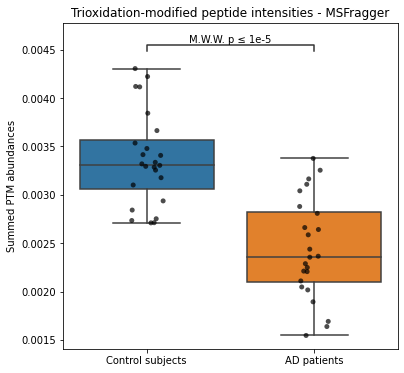

In [27]:
plt.figure(figsize=(6,6))
df = pd.DataFrame({"Control subjects": Controlsums, "AD patients": ADsums})
ax = sns.boxplot(data=df)
pairs = list(combinations(["Control subjects", "AD patients"], r=2))
annotator = Annotator(ax, pairs = pairs, data=df)
annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
annotator.apply_and_annotate()
sns.stripplot(data=df, alpha = 0.7, color="black")

plt.title("{}-modified peptide intensities - MSFragger".format("Trioxidation"))
plt.ylabel("Summed PTM abundances")
plt.savefig("/home/robbe/ionbot/Images/Trioxidation_MSFragger", dpi=300)
plt.show()
